In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as ur
from bbmag import bb_abmag, sigerr
from tdsat_sensitivity import find_limit, compute_snr
from tdsat_telescope import load_telescope_parameters
from astropy.visualization import quantity_support
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [15,10]

In [3]:
# Setup:
td1_band = [180,220]*ur.nm

td2_bandwidth = [40,45,50,55,60,65,70,75,80,85,90,100,120,140,160,180,200]
td2 = []
for w in td2_bandwidth:
    td2.append([260,260+w])
    
td2_band = td2*ur.nm
    
bbtemp = [15000,20000,30000]*ur.K

dist = [100,200]*ur.Mpc

# For the shock model after 1 hr:
swiftmag_sh = -16.5*ur.ABmag

# For the blue kilonova model after 1 hr:
swiftmag_bk = -13.6*ur.ABmag

# Satellite details:
diameter, qe, psf_fwhm,pixel_size, efficiency = load_telescope_parameters(2, diag=True)
outofband_qe = 0.
exposure = 300*ur.s

Telescope Configuration 2
Entrance Pupil diameter 30.0 cm
Optical Effifiency 0.65
PSF FWHM 9.0 arcsec
Pixel size 4.5 arcsec
Effective Aperture 24.18677324489565 cm
Effective Area 459.45792558750725 cm2


In [4]:
# Calculate magnitudes in different bands for the shock model:
bbmag_sh = np.zeros([len(bbtemp),len(td2_band),len(dist),2])
for i in range(0,len(bbtemp)):
    for j in range(0,len(td2_band)):
        for k in range(0,len(dist)):
            bbmag_sh[i,j,k] = bb_abmag(bbtemp=bbtemp[i], bandone=td1_band, 
                                  bandtwo=td2_band[j], swiftmag=swiftmag_sh, 
                                  dist=dist[k], val=True)

In [5]:
# Same for the blue kilonova:
bbmag_bk = np.zeros([len(bbtemp),len(td2_band),len(dist),2])
for i in range(0,len(bbtemp)):
    for j in range(0,len(td2_band)):
        for k in range(0,len(dist)):
            bbmag_bk[i,j,k] = bb_abmag(bbtemp=bbtemp[i], bandone=td1_band, 
                                  bandtwo=td2_band[j], swiftmag=swiftmag_bk, 
                                  dist=dist[k], val=True)

In [6]:
# Calculate signal-to-noise for each band for the shock model (this is quite slow):
snrs_sh = np.zeros([len(bbtemp),len(td2_band),len(dist),2])
for i in range(0,len(bbtemp)):   
    for k in range(0,len(dist)):
        snrs_sh[i,:,k,0] = compute_snr(td1_band,bbmag_sh[i,0,k,0]*ur.ABmag,
                                  med_zodi=True,diameter=diameter,
                                  exposure = exposure,
                                  efficiency = efficiency, qe = qe,
                                  outofband_qe = outofband_qe, psf_size = psf_fwhm)
        for j in range(0,len(td2_band)):
            snrs_sh[i,j,k,1] = compute_snr(td2_band[j],bbmag_sh[i,j,k,1]*ur.ABmag,
                                  med_zodi=True,diameter=diameter,
                                  exposure = exposure,
                                  efficiency = efficiency, qe = qe,
                                  outofband_qe = outofband_qe, psf_size = psf_fwhm)
        
# Now into magnitude errors:
sigs_sh = 2.5*np.log10(1.+1./snrs_sh)

In [7]:
# And for the blue kilonova:
snrs_bk = np.zeros([len(bbtemp),len(td2_band),len(dist),2])
for i in range(0,len(bbtemp)):   
    for k in range(0,len(dist)):
        snrs_bk[i,:,k,0] = compute_snr(td1_band,bbmag_bk[i,0,k,0]*ur.ABmag,
                                  med_zodi=True,diameter=diameter,
                                  exposure = exposure,
                                  efficiency = efficiency, qe = qe,
                                  outofband_qe = outofband_qe, psf_size = psf_fwhm)
        for j in range(0,len(td2_band)):
            snrs_bk[i,j,k,1] = compute_snr(td2_band[j],bbmag_bk[i,j,k,1]*ur.ABmag,
                                  med_zodi=True,diameter=diameter,
                                  exposure = exposure,
                                  efficiency = efficiency, qe = qe,
                                  outofband_qe = outofband_qe, psf_size = psf_fwhm)
            
# Now into magnitude errors:
sigs_bk = 2.5*np.log10(1.+1./snrs_bk)

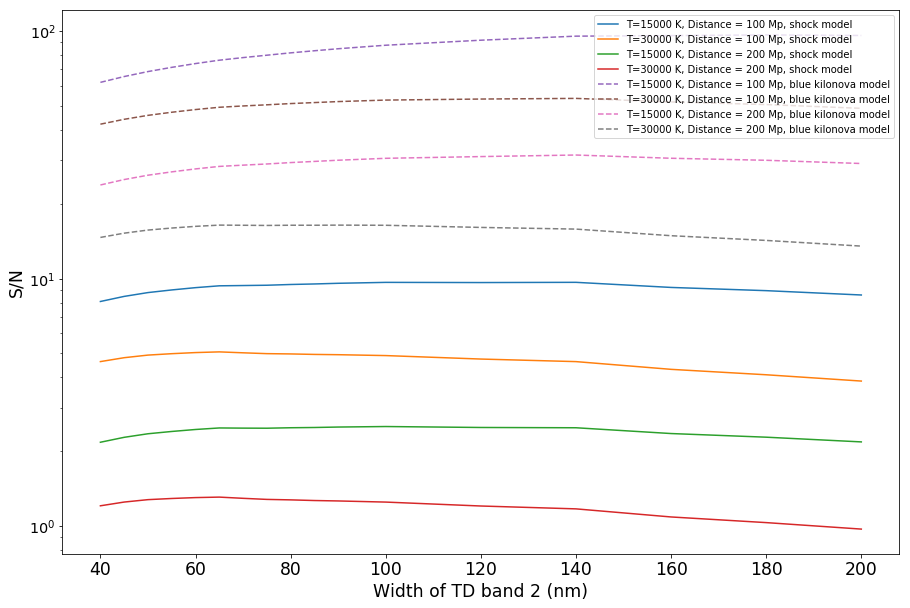

In [8]:
# Plot S/N as a function of bandwidth for TD2:
with quantity_support():
    plt.plot(td2_bandwidth,snrs_bk[0,:,0,1],linestyle='-',label='T=15000 K, Distance = 100 Mp, shock model')
    plt.plot(td2_bandwidth,snrs_bk[2,:,0,1],linestyle='-',label='T=30000 K, Distance = 100 Mp, shock model')
    plt.plot(td2_bandwidth,snrs_bk[0,:,1,1],linestyle='-',label='T=15000 K, Distance = 200 Mp, shock model')
    plt.plot(td2_bandwidth,snrs_bk[2,:,1,1],linestyle='-',label='T=30000 K, Distance = 200 Mp, shock model')
    plt.plot(td2_bandwidth,snrs_sh[0,:,0,1],linestyle='--',label='T=15000 K, Distance = 100 Mp, blue kilonova model')
    plt.plot(td2_bandwidth,snrs_sh[2,:,0,1],linestyle='--',label='T=30000 K, Distance = 100 Mp, blue kilonova model')
    plt.plot(td2_bandwidth,snrs_sh[0,:,1,1],linestyle='--',label='T=15000 K, Distance = 200 Mp, blue kilonova model')
    plt.plot(td2_bandwidth,snrs_sh[2,:,1,1],linestyle='--',label='T=30000 K, Distance = 200 Mp, blue kilonova model')
    
plt.legend()
plt.xlabel('Width of TD band 2 (nm)',fontsize='xx-large')
plt.ylabel('S/N',fontsize='xx-large')
plt.yscale('log')
plt.tick_params(axis='y',which='major',labelsize='x-large')
plt.tick_params(axis='x',which='major',labelsize='xx-large')
#plt.title('Blackbodies scaled to UVW2 of blue kilonova model after 1hr',fontsize='xx-large')
plt.show()

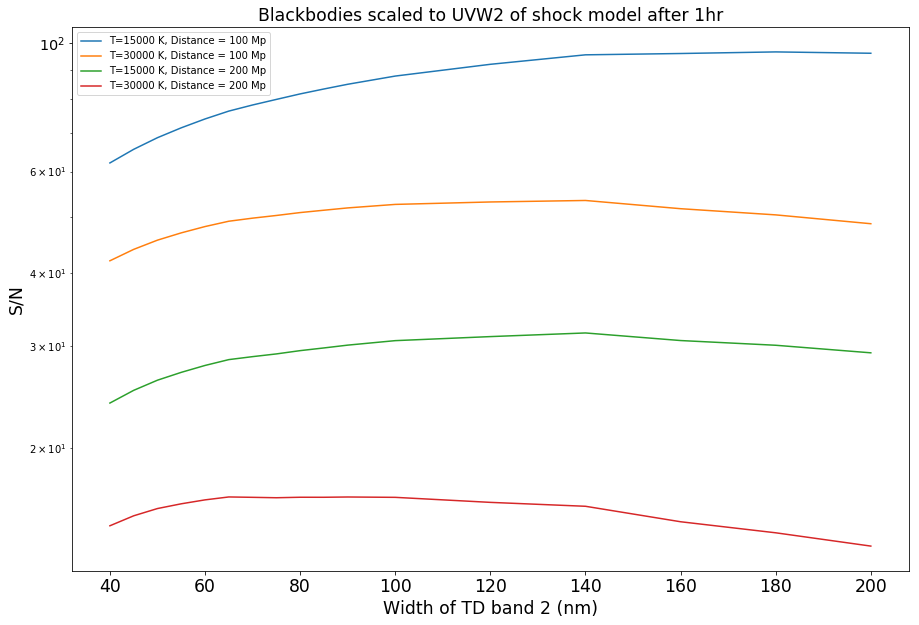

In [9]:
# Plot S/N as a function of bandwidth for TD2:
with quantity_support():
    plt.plot(td2_bandwidth,snrs_sh[0,:,0,1],label='T=15000 K, Distance = 100 Mp')
    plt.plot(td2_bandwidth,snrs_sh[2,:,0,1],label='T=30000 K, Distance = 100 Mp')
    plt.plot(td2_bandwidth,snrs_sh[0,:,1,1],label='T=15000 K, Distance = 200 Mp')
    plt.plot(td2_bandwidth,snrs_sh[2,:,1,1],label='T=30000 K, Distance = 200 Mp')
    
plt.legend()
plt.xlabel('Width of TD band 2 (nm)',fontsize='xx-large')
plt.ylabel('S/N',fontsize='xx-large')
plt.yscale('log')
plt.tick_params(axis='y',which='major',labelsize='x-large')
plt.tick_params(axis='x',which='major',labelsize='xx-large')
plt.title('Blackbodies scaled to UVW2 of shock model after 1hr',fontsize='xx-large')
plt.show()